<a href="https://colab.research.google.com/github/elenakelly/Information-Retrieval-and-Text-Mining/blob/main/02_4_Tutorial_reranking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Start by copying this into your Google Drive!!

# Information Retrieval & Text Mining 2023
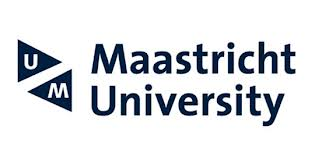
## Tutorial 2 - Notebook 4

In this notebook, we will finetune and evaluate BERT for re-ranking on [MS MACRO](https://huggingface.co/datasets/ms_marco) dataset. We will be using HuggingFace to finetune the model, which makes it easy to plug in any pretrained model on HF Hub that can be used for sequence and classification. The model will be finetuned to output a score between 0 and 1 when given a pair of query and passage. You can check the [original paper](https://arxiv.org/abs/1901.04085) for more details.

In [1]:
!pip install -q transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 46.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 57.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 8.5 MB/s eta 0:00:00


In [2]:
from datasets import Dataset, load_dataset
import torch.nn as nn
import torch
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoTokenizer
import pandas as pd

We start by loading the dataset.

In [3]:
dataset = load_dataset('ms_marco', 'v1.1')
dataset

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating validation split:   0%|          | 0/10047 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/82326 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/9650 [00:00<?, ? examples/s]

Dataset ms_marco downloaded and prepared to /root/.cache/huggingface/datasets/ms_marco/v1.1/1.1.0/b6a62715fa5219aea5275dd3556601004cd63945cb63e36e022f77bb3cbbca84. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    validation: Dataset({
        features: ['answers', 'passages', 'query', 'query_id', 'query_type', 'wellFormedAnswers'],
        num_rows: 10047
    })
    train: Dataset({
        features: ['answers', 'passages', 'query', 'query_id', 'query_type', 'wellFormedAnswers'],
        num_rows: 82326
    })
    test: Dataset({
        features: ['answers', 'passages', 'query', 'query_id', 'query_type', 'wellFormedAnswers'],
        num_rows: 9650
    })
})

We convert the each set to a Pandas DataFrame to make it easier to handle the data.

In [4]:
original_train_df = dataset['train'].to_pandas()
original_validation_df = dataset['validation'].to_pandas()
original_test_df = dataset['test'].to_pandas()

len(original_train_df), len(original_validation_df), len(original_test_df)

(82326, 10047, 9650)

In [5]:
original_validation_df.head()

,answers,passages,query,query_id,query_type,wellFormedAnswers
0,"[Approximately $15,000 per year.]","{'is_selected': [1, 0, 0, 0, 0, 0], 'passage_t...",walgreens store sales average,9652,numeric,[]
1,"[$21,550 per year, The average hourly wage for...","{'is_selected': [0, 1, 0, 0, 0, 0, 0, 0], 'pas...",how much do bartenders make,9653,numeric,[]
2,"[A boil, also called a furuncle, is a deep fol...","{'is_selected': [0, 0, 0, 0, 0, 0, 1, 0], 'pas...",what is a furuncle boil,9654,description,[]
3,"[Detect and assess a wide range of disorders, ...","{'is_selected': [0, 0, 0, 0, 1, 0, 0, 0, 0], '...",what can urinalysis detect,9655,description,[]
4,"[Shigellosis, diseases of the nervous system, ...","{'is_selected': [0, 0, 0, 0, 1, 0, 0, 0, 0], '...",what is vitamin a used for,9656,description,[]


We sample 10% of each set because training on the whole dataset will take a lot of time.

In [6]:
train_df = original_train_df.sample(frac=0.1).reset_index(drop=True)
validation_df = original_validation_df.sample(frac=0.1).reset_index(drop=True)
test_df = original_test_df.sample(frac=0.1).reset_index(drop=True)

len(train_df), len(validation_df), len(test_df)

(8233, 1005, 965)

If you check passages column, you can see it contains a dictionary with keys and values. We will split that dictionary into multiple columns with keys as the column names. 

In [7]:
train_df = pd.concat([train_df, pd.json_normalize(train_df['passages'])], axis=1)
validation_df = pd.concat([validation_df, pd.json_normalize(validation_df['passages'])], axis=1)
test_df = pd.concat([test_df, pd.json_normalize(test_df['passages'])], axis=1)

validation_df.head()

,answers,passages,query,query_id,query_type,wellFormedAnswers,is_selected,passage_text,url
0,[The Salmon Faverolles is a very unique bird t...,"{'is_selected': [0, 0, 0, 0, 0, 0, 0, 0, 1], '...",what are faverolle chickens,13420,entity,[],"[0, 0, 0, 0, 0, 0, 0, 0, 1]","[Cons: not very hardy as chicks or as teens, s...",[http://www.backyardchickens.com/products/fave...
1,[A giant ionic lattice is a highly regular arr...,"{'is_selected': [0, 0, 1, 0, 0, 0, 0, 0, 0], '...",what is an ionic lattice,13252,description,[],"[0, 0, 1, 0, 0, 0, 0, 0, 0]",[Ionic substances form giant ionic lattices la...,[http://www.bbc.co.uk/schools/gcsebitesize/sci...
2,[Any caffine drinks or chocolate],"{'is_selected': [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]...",foods to avoid during implantation,17530,entity,[],"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",[Some foods that pregnant women should avoid a...,[http://fertility.org/threads/foods-to-eat-avo...
3,[24 hours],"{'is_selected': [0, 0, 0, 0, 0, 0, 0, 0, 1], '...",how long should silastic to dry in a shower,12328,numeric,[],"[0, 0, 0, 0, 0, 0, 0, 0, 1]",[Freshly applied silicone caulk has to seal be...,[http://homeguides.sfgate.com/long-should-fres...
4,"[Oxycontin are small round tablets, slightly l...","{'is_selected': [0, 0, 0, 1, 0, 0, 0, 0, 0], '...",what does oxycontin look like,15411,description,[],"[0, 0, 0, 1, 0, 0, 0, 0, 0]",[Oxycodone is found in a few medications. Thes...,[http://www.answers.com/Q/What_does_oxycodone_...


We want our model to take 1 query and 1 `passage_text` and predict the label `is_selected`. We get closer to the format expected by the model by running explode on `is_selected` and `passage_text` columns to get 1 item per row.

In [8]:
train_df = train_df.explode(['is_selected', 'passage_text', 'url'])
validation_df = validation_df.explode(['is_selected', 'passage_text', 'url'])
test_df = test_df.explode(['is_selected', 'passage_text', 'url'])

validation_df.head()

,answers,passages,query,query_id,query_type,wellFormedAnswers,is_selected,passage_text,url
0,[The Salmon Faverolles is a very unique bird t...,"{'is_selected': [0, 0, 0, 0, 0, 0, 0, 0, 1], '...",what are faverolle chickens,13420,entity,[],0,"Cons: not very hardy as chicks or as teens, sm...",http://www.backyardchickens.com/products/faver...
0,[The Salmon Faverolles is a very unique bird t...,"{'is_selected': [0, 0, 0, 0, 0, 0, 0, 0, 1], '...",what are faverolle chickens,13420,entity,[],0,More Breed Availability. The Faverolles is one...,http://www.mypetchicken.com/catalog/Day-Old-Ba...
0,[The Salmon Faverolles is a very unique bird t...,"{'is_selected': [0, 0, 0, 0, 0, 0, 0, 0, 1], '...",what are faverolle chickens,13420,entity,[],0,Photo: Salmon Favorolles hen. F averolles chic...,https://poultrykeeper.com/chicken-breeds/faver...
0,[The Salmon Faverolles is a very unique bird t...,"{'is_selected': [0, 0, 0, 0, 0, 0, 0, 0, 1], '...",what are faverolle chickens,13420,entity,[],0,"In breeding Faverolles, the color of the pluma...",http://northwoodspoultry.com/salmon-faverolles...
0,[The Salmon Faverolles is a very unique bird t...,"{'is_selected': [0, 0, 0, 0, 0, 0, 0, 0, 1], '...",what are faverolle chickens,13420,entity,[],0,Email me when this is Available. Salmon Favero...,http://www.efowl.com/Salmon_Faverolle_Chickens...


In [9]:
len(train_df), len(validation_df), len(test_df)

(67491, 8315, 7965)

Below we use [distilbert-base-uncased](https://huggingface.co/distilbert-base-uncased) as it is smaller and faster. The model is expected to take a query and a passage and predict a probability of the passage being relevant. by passing 1 to `num_labels`, HuggingFace will add a linear layer with 1 single output, and that is what we need to get our probability.

In [10]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=1)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

After passing a list of queries and passages to the tokenizer, it will automatically concatenate them and put a \[SEP] token in between.

In [11]:
out = tokenizer(["query"], ["passage"])
decoded_out = tokenizer.decode(out['input_ids'][0])

print(f"Model input: {out}")
print(f"Model input decoded: {decoded_out}")

Model input: {'input_ids': [[101, 23032, 102, 6019, 102]], 'attention_mask': [[1, 1, 1, 1, 1]]}
Model input decoded: [CLS] query [SEP] passage [SEP]


The model takes a tokenized pair and output one logit.

In [12]:
model(**tokenizer(["query"], ["document"], return_tensors='pt'))

SequenceClassifierOutput(loss=None, logits=tensor([[0.0981]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [13]:
train_df = train_df.rename(columns={'is_selected': 'labels'})
validation_df = validation_df.rename(columns={'is_selected': 'labels'})
test_df = test_df.rename(columns={'is_selected': 'labels'})

In [14]:
train_dataset = Dataset.from_pandas(train_df, preserve_index=False)
validation_dataset = Dataset.from_pandas(validation_df, preserve_index=False)
test_dataset = Dataset.from_pandas(test_df, preserve_index=False)

validation_dataset

Dataset({
    features: ['answers', 'passages', 'query', 'query_id', 'query_type', 'wellFormedAnswers', 'labels', 'passage_text', 'url'],
    num_rows: 8315
})

In [15]:
def preprocess_function(examples):
    return tokenizer(examples["query"], examples["passage_text"], truncation=True, padding=True)

tokenized_train_dataset = train_dataset.map(preprocess_function, batched=True)
tokenized_validation_dataset = validation_dataset.map(preprocess_function, batched=True)
tokenized_test_dataset = test_dataset.map(preprocess_function, batched=True)

tokenized_validation_dataset

Map:   0%|          | 0/67491 [00:00<?, ? examples/s]

Map:   0%|          | 0/8315 [00:00<?, ? examples/s]

Map:   0%|          | 0/7965 [00:00<?, ? examples/s]

Dataset({
    features: ['answers', 'passages', 'query', 'query_id', 'query_type', 'wellFormedAnswers', 'labels', 'passage_text', 'url', 'input_ids', 'attention_mask'],
    num_rows: 8315
})

We need to customize the trainer to compute binary cross entropy loss. We turn logits into probabilities by applying sigmoid function, then we compute our loss. 

### Exercise #1
Update the code below to use [nn.BCEWithLogitsLoss()](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) instead of nn.BCELoss.

In [16]:
class BCELossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels").to(torch.float32)
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.BCELoss()
        sigmoid = nn.Sigmoid()
        probs = sigmoid(logits)
        loss = loss_fct(probs.view(-1), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [22]:
class BCELossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels").to(torch.float32)
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.BCEWithLogitsLoss()
        loss = loss_fct(logits.view(-1), labels.view(-1))
        return (loss, outputs) if return_outputs else loss


We clone the [original paper implementation repository](https://github.com/nyu-dl/dl4marco-bert) to be able to use the metrics they defined.

In [23]:
import sys

!test -d bert_repo || git clone https://github.com/maryszmary/dl4marco-bert dl4marco-bert
if not 'dl4marco-bert' in sys.path:
  sys.path += ['dl4marco-bert']

fatal: destination path 'dl4marco-bert' already exists and is not an empty directory.


We format labels and scores as expected by metrics. We need to pass a set of ground truth document ids (in this case it's indices where label is larger than 1) and ordered document ids from most relevant to least that we order based on the scores.

In [24]:
import numpy as np
import metrics

METRICS_MAP = ['MAP', 'RPrec', 'NDCG', 'MRR', 'MRR@10']

labels = np.array([1, 0, 0])
scores = np.array([0.1, 0.8, 0.3])

gt = set(list(np.where(labels > 0)[0]))
pred_docs = scores.argsort()[::-1]

results = metrics.metrics(gt=gt, pred=pred_docs, metrics_map=METRICS_MAP)

print(f"Ground Truth: {gt}")
print(f"Predicted docs: {pred_docs}")
print(f"Results: {results}")

Ground Truth: {0}
Predicted docs: [1 2 0]
Results: [0.33333334 0.         0.5        0.33333334 0.33333334]


To compute metrics, we need a list of labels and predictions for each query instead of the exploded version that we prepared before to train the model. That is why we group by `query_ids`.

In [25]:
def prepare_compute_metrics(query_ids):
  def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.squeeze()
    df = pd.DataFrame.from_dict({'labels': labels, 'preds': preds, 'query_ids': query_ids})
    df = df.groupby('query_ids').agg(list)
    
    df['labels'] = df['labels'].map(lambda x: set(list(np.where(np.array(x) > 0)[0])))
    df['preds'] = df['preds'].map(lambda x: np.array(x).argsort()[::-1])

    all_metrics = np.zeros(len(METRICS_MAP))
    for _, row in df.iterrows():
      all_metrics+=metrics.metrics(row['labels'], row['preds'], metrics_map=METRICS_MAP)

    all_metrics/=len(df)
    
    return {
        metric: result for metric, result in zip(METRICS_MAP, all_metrics)
    }

  return compute_metrics

query_ids = tokenized_validation_dataset['query_id']
compute_metrics = prepare_compute_metrics(query_ids)

In [26]:
training_args = TrainingArguments(
    output_dir="bert_reranker",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2
)

In [27]:
trainer = BCELossTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_validation_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Map,Rprec,Ndcg,Mrr,Mrr@10
1,0.372600,0.359506,0.517836,0.333499,0.626140,0.527858,0.527858
2,0.350100,0.357603,0.530019,0.348756,0.635608,0.540908,0.540908
3,0.311300,0.371053,0.543238,0.360365,0.645941,0.554129,0.554129


TrainOutput(global_step=6330, training_loss=0.34770731993761106, metrics={'train_runtime': 4365.827, 'train_samples_per_second': 46.377, 'train_steps_per_second': 1.45, 'total_flos': 1.3568426783238912e+16, 'train_loss': 0.34770731993761106, 'epoch': 3.0})

### Exercise #2
Write code to get metric results of the model on the test set.

In [36]:
# Initialize the Trainer with the compute_metrics function for the test dataset
trainer_test = BCELossTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics_test
)

# Evaluate the model on the test dataset and get the metric results
eval_results = trainer_test.evaluate()

# Print the metric results
print(eval_results)



{'eval_loss': 0.37765276432037354, 'eval_MAP': 0.5308104092670228, 'eval_RPrec': 0.3395509499959995, 'eval_NDCG': 0.6413460086355556, 'eval_MRR': 0.5432523253127701, 'eval_MRR@10': 0.5432523253127701, 'eval_runtime': 50.0594, 'eval_samples_per_second': 159.111, 'eval_steps_per_second': 4.974}


###Exercise #3
Save the model, then load it back and use it to predict scores for the lists of queries and passages below.

In [40]:
queries = original_validation_df.loc[0:5, 'query'].tolist()
passages = original_validation_df.loc[0:5, 'passages'].tolist()

In [ ]:
# Save the trained model
model_dir = "bert_reranker"
trainer.save_model(model_dir)

# Load the saved model
model_loaded = AutoModelForSequenceClassification.from_pretrained(model_dir)

# Get the tokenized input for the queries and passages
inputs = tokenizer(queries, passages, truncation=True, padding=True)

# Make predictions using the loaded model
outputs = model_loaded(**inputs)

# Get the predicted scores
scores = torch.sigmoid(outputs.logits).squeeze().tolist()

# Print the predicted scores for each query and passage pair
for i, (query, passage) in enumerate(zip(queries, passages)):
    print(f"Query {i+1}: {query}")
    print(f"Passage {i+1}: {passage}")
    print(f"Score {i+1}: {scores[i]}")
    print()
